#  Montrer la garantie du passage à l’échelle

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from time import time
import numpy as np
#sc.stop()
spark = SparkSession.builder\
        .master("local[*]")\
        .appName("adult_data")\
        .getOrCreate()

In [2]:
from pyspark import SparkContext
sc = spark.sparkContext.getOrCreate()

In [3]:
spark

In [5]:
path="adult1.data"
data = spark.read.csv(path, inferSchema=True)

In [6]:
data=data.sample(0.3)
data.count()

2565336

In [7]:
data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: double (nullable = true)
 |-- _c11: double (nullable = true)
 |-- _c12: double (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)



In [8]:
new_names=[('_c0','age'),('_c1','workclass'),('_c2','fnlwgt'),('_c3','education'),('_c4','education_num'),('_c5','marital_status'),('_c6','occupation'),('_c7','relationship'),('_c8','race'),('_c9','sex'),('_c10','capital_gain'),('_c11','capital_loss'),('_c12','hours_per_week'),('_c13','native_country'),('_c14','classe')]
for old_name,new_name in new_names:
    data=data.withColumnRenamed(old_name,new_name)

In [9]:
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- classe: string (nullable = true)



In [10]:
data=data.drop("native_country")

In [11]:
from pyspark.ml.feature import StringIndexer
indexer=StringIndexer().setInputCols(["workclass","education","marital_status","occupation","relationship","race","sex","classe"]).setOutputCols(["workclass_indexed","education_indexed","marital_status_indexed","occupation_indexed","relationship_indexed","race_indexed","sex_indexed","classe_indexed"])

In [12]:
indexed=indexer.fit(data).transform(data)

In [13]:
assembleur = VectorAssembler()\
    .setInputCols(['age','workclass_indexed','fnlwgt','education_indexed','education_num','marital_status_indexed','occupation_indexed','relationship_indexed','race_indexed','sex_indexed'])\
    .setOutputCol("features")

In [14]:
output=assembleur.transform(indexed)

In [15]:
model_data=output.select("features","classe_indexed")

In [16]:
model_data.show(2)

+--------------------+--------------+
|            features|classe_indexed|
+--------------------+--------------+
|[32.0,0.0,205019....|           0.0|
|[32.0,0.0,186824....|           0.0|
+--------------------+--------------+
only showing top 2 rows



# Résultat de l'expérimentation

In [17]:
time_prediction=[]
classifier = DecisionTreeClassifier(labelCol="classe_indexed", featuresCol="features")
# add empty parameter grid 
paramGrid = (ParamGridBuilder()
             .addGrid(classifier.maxDepth, [2,5,10,15,20,25]) # max depth parameter 
             .build())
    
# create evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="classe_indexed")

# create cross validation object
crossval = CrossValidator(estimator=classifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 
for i in np.arange(0.05,1.05,0.05):
    sample=model_data.sample(i,123)
    (trainingData, testData) = sample.randomSplit([0.7, 0.3])

    t0 = time()
    # run cross-validation, and choose the best set of parameters.
    Model = crossval.fit(trainingData)
    #tt = time() - t0

    #print ("Classifier trained in {} seconds".format(round(tt,3)))
    #t0 = time()

    # make predictions on test data 
    predictions = Model.transform(testData)

    tt = time() - t0
    time_prediction.append(tt)
    b=i*100
    print ("Classifier predict sample {}% in {} seconds".format(b,round(tt,3)))
    #acc = evaluator.evaluate(predictions)
    #print("Prediction Accuracy: ", predictions)

    #y_pred=predictions.select("prediction").collect()
    #y_orig=predictions.select("classe_indexed").collect()

    #cm = confusion_matrix(y_orig, y_pred)
    #print("Confusion Matrix:", cm)
    #print('Accuracy:', evaluator.evaluate(predictions))

Classifier predict sample 5.0% in 284.878 seconds
Classifier predict sample 10.0% in 273.202 seconds
Classifier predict sample 15.000000000000002% in 281.397 seconds
Classifier predict sample 20.0% in 265.693 seconds
Classifier predict sample 25.0% in 275.886 seconds
Classifier predict sample 30.0% in 275.695 seconds
Classifier predict sample 35.0% in 279.54 seconds
Classifier predict sample 40.0% in 283.064 seconds
Classifier predict sample 45.0% in 368.933 seconds
Classifier predict sample 50.0% in 331.279 seconds
Classifier predict sample 55.00000000000001% in 342.574 seconds
Classifier predict sample 60.00000000000001% in 354.937 seconds
Classifier predict sample 65.00000000000001% in 343.872 seconds
Classifier predict sample 70.0% in 348.28 seconds
Classifier predict sample 75.00000000000001% in 357.328 seconds
Classifier predict sample 80.0% in 367.078 seconds
Classifier predict sample 85.00000000000001% in 376.934 seconds
Classifier predict sample 90.00000000000001% in 383.415 s

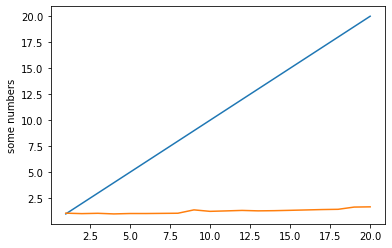

In [18]:
T=[]
S=np.array(time_prediction)
for i in np.arange(0.05,1.05,0.05):
    b=i/0.05
    T.append(b)
#S=np.array([34.505,33.306,35.846,35.708,38.136,37.237,43.079,40.751,43.77,41.608,45.652,43.326,46.551,46.081,48.126,48.684,50.077,49.924,51.885]) 
time_prediction=S/min(time_prediction)

import matplotlib.pyplot as plt
plt.plot(T,T)
plt.plot(T,time_prediction)
plt.ylabel('some numbers')
plt.show()

In [87]:
acc = evaluator.evaluate(predictions)
print("Prediction Accuracy: ", predictions)

y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("classe_indexed").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)
print('Accuracy:', evaluator.evaluate(predictions))

Prediction Accuracy:  DataFrame[features: vector, classe_indexed: double, rawPrediction: vector, probability: vector, prediction: double]
Confusion Matrix:
[[6271  689]
 [ 813 1394]]
Accuracy: 0.8345067795666556


# exprimentation avec 2 coeurs

In [9]:
sc.stop()

In [1]:
import findspark
findspark.init() 
from pyspark.sql import SparkSession
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from time import time
import numpy as np
spark = SparkSession.builder\
        .master("local[2]")\
        .appName("test_avec_2coeur")\
        .getOrCreate()

In [2]:
from pyspark import SparkContext
sc = spark.sparkContext.getOrCreate()

In [3]:
from pyspark.ml.feature import StringIndexer
path="adult2.data"
data = spark.read.csv(path, inferSchema=True)
new_names=[('_c0','age'),('_c1','workclass'),('_c2','fnlwgt'),('_c3','education'),('_c4','education_num'),('_c5','marital_status'),('_c6','occupation'),('_c7','relationship'),('_c8','race'),('_c9','sex'),('_c10','capital_gain'),('_c11','capital_loss'),('_c12','hours_per_week'),('_c13','native_country'),('_c14','classe')]
for old_name,new_name in new_names:
    data=data.withColumnRenamed(old_name,new_name)
data=data.drop("native_country")
from pyspark.ml.feature import StringIndexer
workclass_indexer = StringIndexer().setInputCol("workclass").setOutputCol("workclass_indexed")
education_indexer = StringIndexer().setInputCol("education").setOutputCol("education_indexed")
marital_status_indexer = StringIndexer().setInputCol("marital_status").setOutputCol("marital_status_indexed")
occupation_indexer = StringIndexer().setInputCol("occupation").setOutputCol("occupation_indexed")
relationship_indexer = StringIndexer().setInputCol("relationship").setOutputCol("relationship_indexed")
race_indexer = StringIndexer().setInputCol("race").setOutputCol("race_indexed")
sex_indexer = StringIndexer().setInputCol("sex").setOutputCol("sex_indexed")
classe_indexer = StringIndexer().setInputCol("classe").setOutputCol("classe_indexed")

numCol = ["age",'fnlwgt', 'education_num' ]

from pyspark.ml.feature import VectorAssembler

assembleur = VectorAssembler()\
    .setInputCols(['workclass_indexed','education_indexed','marital_status_indexed','occupation_indexed','relationship_indexed','race_indexed','sex_indexed'] + numCol)\
    .setOutputCol("features")

from pyspark.ml import Pipeline

#définition du pipeline
transformationPipeline = Pipeline()\
                        .setStages([classe_indexer, sex_indexer, race_indexer, relationship_indexer ,occupation_indexer, marital_status_indexer, education_indexer, workclass_indexer,  assembleur])


#la fonction fit pour rencenser les valeurs possibles des index pour chaque variable à partir du dataframe 
fittedPipeline = transformationPipeline.fit(data)

#appliquer les résultats de la fonction fit pour transformer le DataFrame en ajoutnat les nouvelles colonnes.
#on obtien une nouvelle dataframe
transformedTraining = fittedPipeline.transform(data)
model_data=transformedTraining.select("features","classe_indexed")

In [4]:
trainingData=model_data.sample(0.7,123)
testData=model_data.sample(0.3,123)

In [5]:
time_prediction=[]
classifier = DecisionTreeClassifier(labelCol="classe_indexed", featuresCol="features")
# add empty parameter grid 
paramGrid = (ParamGridBuilder()
             .addGrid(classifier.maxDepth, [2,5,10,15,20,25]) # max depth parameter 
             .build())
    
# create evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="classe_indexed")

# create cross validation object
crossval = CrossValidator(estimator=classifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 

#model_data=model_data.sample(0.1,123)
#(trainingData, testData) = model_data.randomSplit([0.7, 0.3])

t0 = time()
# run cross-validation, and choose the best set of parameters.
Model = crossval.fit(trainingData)
# make predictions on test data 
predictions = Model.transform(testData)
tt = time() - t0
acc = evaluator.evaluate(predictions)
print("Prediction Accuracy: ", predictions)

y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("classe_indexed").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)
print('Accuracy:', evaluator.evaluate(predictions))
print ("Classifier trained in {} seconds".format(round(tt,3)))

Prediction Accuracy:  DataFrame[features: vector, classe_indexed: double, rawPrediction: vector, probability: vector, prediction: double]
Confusion Matrix:
[[6850  626]
 [ 809 1591]]
Accuracy: 0.8526970939481168
Classifier trained in 41.718 seconds


# 4 coeurs

In [6]:
sc.stop()

In [7]:
import findspark
findspark.init() 
from pyspark.sql import SparkSession
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from time import time
import numpy as np
spark = SparkSession.builder\
        .master("local[4]")\
        .appName("test_avec_4coeur")\
        .getOrCreate()

In [8]:
from pyspark import SparkContext
sc = spark.sparkContext.getOrCreate()

In [9]:
from pyspark.ml.feature import StringIndexer
path="adult2.data"
data = spark.read.csv(path, inferSchema=True)
new_names=[('_c0','age'),('_c1','workclass'),('_c2','fnlwgt'),('_c3','education'),('_c4','education_num'),('_c5','marital_status'),('_c6','occupation'),('_c7','relationship'),('_c8','race'),('_c9','sex'),('_c10','capital_gain'),('_c11','capital_loss'),('_c12','hours_per_week'),('_c13','native_country'),('_c14','classe')]
for old_name,new_name in new_names:
    data=data.withColumnRenamed(old_name,new_name)
data=data.drop("native_country")
from pyspark.ml.feature import StringIndexer
workclass_indexer = StringIndexer().setInputCol("workclass").setOutputCol("workclass_indexed")
education_indexer = StringIndexer().setInputCol("education").setOutputCol("education_indexed")
marital_status_indexer = StringIndexer().setInputCol("marital_status").setOutputCol("marital_status_indexed")
occupation_indexer = StringIndexer().setInputCol("occupation").setOutputCol("occupation_indexed")
relationship_indexer = StringIndexer().setInputCol("relationship").setOutputCol("relationship_indexed")
race_indexer = StringIndexer().setInputCol("race").setOutputCol("race_indexed")
sex_indexer = StringIndexer().setInputCol("sex").setOutputCol("sex_indexed")
classe_indexer = StringIndexer().setInputCol("classe").setOutputCol("classe_indexed")

numCol = ["age",'fnlwgt', 'education_num' ]

from pyspark.ml.feature import VectorAssembler

assembleur = VectorAssembler()\
    .setInputCols(['workclass_indexed','education_indexed','marital_status_indexed','occupation_indexed','relationship_indexed','race_indexed','sex_indexed'] + numCol)\
    .setOutputCol("features")

from pyspark.ml import Pipeline

#définition du pipeline
transformationPipeline = Pipeline()\
                        .setStages([classe_indexer, sex_indexer, race_indexer, relationship_indexer ,occupation_indexer, marital_status_indexer, education_indexer, workclass_indexer,  assembleur])


#la fonction fit pour rencenser les valeurs possibles des index pour chaque variable à partir du dataframe 
fittedPipeline = transformationPipeline.fit(data)

#appliquer les résultats de la fonction fit pour transformer le DataFrame en ajoutnat les nouvelles colonnes.
#on obtien une nouvelle dataframe
transformedTraining = fittedPipeline.transform(data)
model_data=transformedTraining.select("features","classe_indexed")

In [10]:
trainingData=model_data.sample(0.7,123)
testData=model_data.sample(0.3,123)

In [11]:
time_prediction=[]
classifier = DecisionTreeClassifier(labelCol="classe_indexed", featuresCol="features")
# add empty parameter grid 
paramGrid = (ParamGridBuilder()
             .addGrid(classifier.maxDepth, [2,5,10,15,20,25]) # max depth parameter 
             .build())
    
# create evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="classe_indexed")

# create cross validation object
crossval = CrossValidator(estimator=classifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 

#model_data=model_data.sample(0.1,123)
#(trainingData, testData) = model_data.randomSplit([0.7, 0.3])

t0 = time()
# run cross-validation, and choose the best set of parameters.
Model = crossval.fit(trainingData)
# make predictions on test data 
predictions = Model.transform(testData)
tt = time() - t0
acc = evaluator.evaluate(predictions)
print("Prediction Accuracy: ", predictions)

y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("classe_indexed").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)
print('Accuracy:', evaluator.evaluate(predictions))
print ("Classifier trained in {} seconds".format(round(tt,3)))

Prediction Accuracy:  DataFrame[features: vector, classe_indexed: double, rawPrediction: vector, probability: vector, prediction: double]
Confusion Matrix:
[[6850  626]
 [ 809 1591]]
Accuracy: 0.8526970939481168
Classifier trained in 40.095 seconds


# 6 coeurs

In [12]:
sc.stop()

In [13]:
import findspark
findspark.init() 
from pyspark.sql import SparkSession
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from time import time
import numpy as np
spark = SparkSession.builder\
        .master("local[6]")\
        .appName("test_avec_6coeur")\
        .getOrCreate()

from pyspark import SparkContext
sc = spark.sparkContext.getOrCreate()

from pyspark.ml.feature import StringIndexer
path="adult2.data"
data = spark.read.csv(path, inferSchema=True)
new_names=[('_c0','age'),('_c1','workclass'),('_c2','fnlwgt'),('_c3','education'),('_c4','education_num'),('_c5','marital_status'),('_c6','occupation'),('_c7','relationship'),('_c8','race'),('_c9','sex'),('_c10','capital_gain'),('_c11','capital_loss'),('_c12','hours_per_week'),('_c13','native_country'),('_c14','classe')]
for old_name,new_name in new_names:
    data=data.withColumnRenamed(old_name,new_name)
data=data.drop("native_country")
from pyspark.ml.feature import StringIndexer
workclass_indexer = StringIndexer().setInputCol("workclass").setOutputCol("workclass_indexed")
education_indexer = StringIndexer().setInputCol("education").setOutputCol("education_indexed")
marital_status_indexer = StringIndexer().setInputCol("marital_status").setOutputCol("marital_status_indexed")
occupation_indexer = StringIndexer().setInputCol("occupation").setOutputCol("occupation_indexed")
relationship_indexer = StringIndexer().setInputCol("relationship").setOutputCol("relationship_indexed")
race_indexer = StringIndexer().setInputCol("race").setOutputCol("race_indexed")
sex_indexer = StringIndexer().setInputCol("sex").setOutputCol("sex_indexed")
classe_indexer = StringIndexer().setInputCol("classe").setOutputCol("classe_indexed")

numCol = ["age",'fnlwgt', 'education_num' ]

from pyspark.ml.feature import VectorAssembler

assembleur = VectorAssembler()\
    .setInputCols(['workclass_indexed','education_indexed','marital_status_indexed','occupation_indexed','relationship_indexed','race_indexed','sex_indexed'] + numCol)\
    .setOutputCol("features")

from pyspark.ml import Pipeline

#définition du pipeline
transformationPipeline = Pipeline()\
                        .setStages([classe_indexer, sex_indexer, race_indexer, relationship_indexer ,occupation_indexer, marital_status_indexer, education_indexer, workclass_indexer,  assembleur])


#la fonction fit pour rencenser les valeurs possibles des index pour chaque variable à partir du dataframe 
fittedPipeline = transformationPipeline.fit(data)

#appliquer les résultats de la fonction fit pour transformer le DataFrame en ajoutnat les nouvelles colonnes.
#on obtien une nouvelle dataframe
transformedTraining = fittedPipeline.transform(data)
model_data=transformedTraining.select("features","classe_indexed")

In [14]:
trainingData=model_data.sample(0.7,123)
testData=model_data.sample(0.3,123)

In [15]:
time_prediction=[]
classifier = DecisionTreeClassifier(labelCol="classe_indexed", featuresCol="features")
# add empty parameter grid 
paramGrid = (ParamGridBuilder()
             .addGrid(classifier.maxDepth, [2,5,10,15,20,25]) # max depth parameter 
             .build())
    
# create evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="classe_indexed")

# create cross validation object
crossval = CrossValidator(estimator=classifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 

#model_data=model_data.sample(0.1,123)
#(trainingData, testData) = model_data.randomSplit([0.7, 0.3])

t0 = time()
# run cross-validation, and choose the best set of parameters.
Model = crossval.fit(trainingData)
# make predictions on test data 
predictions = Model.transform(testData)
tt = time() - t0
acc = evaluator.evaluate(predictions)
print("Prediction Accuracy: ", predictions)

y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("classe_indexed").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)
print('Accuracy:', evaluator.evaluate(predictions))
print ("Classifier trained in {} seconds".format(round(tt,3)))

Prediction Accuracy:  DataFrame[features: vector, classe_indexed: double, rawPrediction: vector, probability: vector, prediction: double]
Confusion Matrix:
[[6850  626]
 [ 809 1591]]
Accuracy: 0.8526970939481168
Classifier trained in 39.699 seconds


# 8 coeurs

In [16]:
sc.stop()

In [17]:
import findspark
findspark.init() 
from pyspark.sql import SparkSession
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from time import time
import numpy as np
spark = SparkSession.builder\
        .master("local[8]")\
        .appName("test_avec_8coeur")\
        .getOrCreate()

from pyspark import SparkContext
sc = spark.sparkContext.getOrCreate()

from pyspark.ml.feature import StringIndexer
path="adult2.data"
data = spark.read.csv(path, inferSchema=True)
new_names=[('_c0','age'),('_c1','workclass'),('_c2','fnlwgt'),('_c3','education'),('_c4','education_num'),('_c5','marital_status'),('_c6','occupation'),('_c7','relationship'),('_c8','race'),('_c9','sex'),('_c10','capital_gain'),('_c11','capital_loss'),('_c12','hours_per_week'),('_c13','native_country'),('_c14','classe')]
for old_name,new_name in new_names:
    data=data.withColumnRenamed(old_name,new_name)
data=data.drop("native_country")
from pyspark.ml.feature import StringIndexer
workclass_indexer = StringIndexer().setInputCol("workclass").setOutputCol("workclass_indexed")
education_indexer = StringIndexer().setInputCol("education").setOutputCol("education_indexed")
marital_status_indexer = StringIndexer().setInputCol("marital_status").setOutputCol("marital_status_indexed")
occupation_indexer = StringIndexer().setInputCol("occupation").setOutputCol("occupation_indexed")
relationship_indexer = StringIndexer().setInputCol("relationship").setOutputCol("relationship_indexed")
race_indexer = StringIndexer().setInputCol("race").setOutputCol("race_indexed")
sex_indexer = StringIndexer().setInputCol("sex").setOutputCol("sex_indexed")
classe_indexer = StringIndexer().setInputCol("classe").setOutputCol("classe_indexed")

numCol = ["age",'fnlwgt', 'education_num' ]

from pyspark.ml.feature import VectorAssembler

assembleur = VectorAssembler()\
    .setInputCols(['workclass_indexed','education_indexed','marital_status_indexed','occupation_indexed','relationship_indexed','race_indexed','sex_indexed'] + numCol)\
    .setOutputCol("features")

from pyspark.ml import Pipeline

#définition du pipeline
transformationPipeline = Pipeline()\
                        .setStages([classe_indexer, sex_indexer, race_indexer, relationship_indexer ,occupation_indexer, marital_status_indexer, education_indexer, workclass_indexer,  assembleur])


#la fonction fit pour rencenser les valeurs possibles des index pour chaque variable à partir du dataframe 
fittedPipeline = transformationPipeline.fit(data)

#appliquer les résultats de la fonction fit pour transformer le DataFrame en ajoutnat les nouvelles colonnes.
#on obtien une nouvelle dataframe
transformedTraining = fittedPipeline.transform(data)
model_data=transformedTraining.select("features","classe_indexed")

In [18]:
trainingData=model_data.sample(0.7,123)
testData=model_data.sample(0.3,123)

In [19]:
time_prediction=[]
classifier = DecisionTreeClassifier(labelCol="classe_indexed", featuresCol="features")
# add empty parameter grid 
paramGrid = (ParamGridBuilder()
             .addGrid(classifier.maxDepth, [2,5,10,15,20,25]) # max depth parameter 
             .build())
    
# create evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="classe_indexed")

# create cross validation object
crossval = CrossValidator(estimator=classifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 

#model_data=model_data.sample(0.1,123)
#(trainingData, testData) = model_data.randomSplit([0.7, 0.3])

t0 = time()
# run cross-validation, and choose the best set of parameters.
Model = crossval.fit(trainingData)
# make predictions on test data 
predictions = Model.transform(testData)
tt = time() - t0
acc = evaluator.evaluate(predictions)
print("Prediction Accuracy: ", predictions)

y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("classe_indexed").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)
print('Accuracy:', evaluator.evaluate(predictions))
print ("Classifier trained in {} seconds".format(round(tt,3)))

Prediction Accuracy:  DataFrame[features: vector, classe_indexed: double, rawPrediction: vector, probability: vector, prediction: double]
Confusion Matrix:
[[6850  626]
 [ 809 1591]]
Accuracy: 0.8526970939481168
Classifier trained in 39.579 seconds


# 10 coeurs

In [20]:
sc.stop()

In [21]:
import findspark
findspark.init() 
from pyspark.sql import SparkSession
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from time import time
import numpy as np
spark = SparkSession.builder\
        .master("local[10]")\
        .appName("test_avec_10coeur")\
        .getOrCreate()

from pyspark import SparkContext
sc = spark.sparkContext.getOrCreate()

from pyspark.ml.feature import StringIndexer
path="adult2.data"
data = spark.read.csv(path, inferSchema=True)
new_names=[('_c0','age'),('_c1','workclass'),('_c2','fnlwgt'),('_c3','education'),('_c4','education_num'),('_c5','marital_status'),('_c6','occupation'),('_c7','relationship'),('_c8','race'),('_c9','sex'),('_c10','capital_gain'),('_c11','capital_loss'),('_c12','hours_per_week'),('_c13','native_country'),('_c14','classe')]
for old_name,new_name in new_names:
    data=data.withColumnRenamed(old_name,new_name)
data=data.drop("native_country")
from pyspark.ml.feature import StringIndexer
workclass_indexer = StringIndexer().setInputCol("workclass").setOutputCol("workclass_indexed")
education_indexer = StringIndexer().setInputCol("education").setOutputCol("education_indexed")
marital_status_indexer = StringIndexer().setInputCol("marital_status").setOutputCol("marital_status_indexed")
occupation_indexer = StringIndexer().setInputCol("occupation").setOutputCol("occupation_indexed")
relationship_indexer = StringIndexer().setInputCol("relationship").setOutputCol("relationship_indexed")
race_indexer = StringIndexer().setInputCol("race").setOutputCol("race_indexed")
sex_indexer = StringIndexer().setInputCol("sex").setOutputCol("sex_indexed")
classe_indexer = StringIndexer().setInputCol("classe").setOutputCol("classe_indexed")

numCol = ["age",'fnlwgt', 'education_num' ]

from pyspark.ml.feature import VectorAssembler

assembleur = VectorAssembler()\
    .setInputCols(['workclass_indexed','education_indexed','marital_status_indexed','occupation_indexed','relationship_indexed','race_indexed','sex_indexed'] + numCol)\
    .setOutputCol("features")

from pyspark.ml import Pipeline

#définition du pipeline
transformationPipeline = Pipeline()\
                        .setStages([classe_indexer, sex_indexer, race_indexer, relationship_indexer ,occupation_indexer, marital_status_indexer, education_indexer, workclass_indexer,  assembleur])


#la fonction fit pour rencenser les valeurs possibles des index pour chaque variable à partir du dataframe 
fittedPipeline = transformationPipeline.fit(data)

#appliquer les résultats de la fonction fit pour transformer le DataFrame en ajoutnat les nouvelles colonnes.
#on obtien une nouvelle dataframe
transformedTraining = fittedPipeline.transform(data)
model_data=transformedTraining.select("features","classe_indexed")

In [22]:
trainingData=model_data.sample(0.7,123)
testData=model_data.sample(0.3,123)

In [23]:
time_prediction=[]
classifier = DecisionTreeClassifier(labelCol="classe_indexed", featuresCol="features")
# add empty parameter grid 
paramGrid = (ParamGridBuilder()
             .addGrid(classifier.maxDepth, [2,5,10,15,20,25]) # max depth parameter 
             .build())
    
# create evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="classe_indexed")

# create cross validation object
crossval = CrossValidator(estimator=classifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 

#model_data=model_data.sample(0.1,123)
#(trainingData, testData) = model_data.randomSplit([0.7, 0.3])

t0 = time()
# run cross-validation, and choose the best set of parameters.
Model = crossval.fit(trainingData)
# make predictions on test data 
predictions = Model.transform(testData)
tt = time() - t0
acc = evaluator.evaluate(predictions)
print("Prediction Accuracy: ", predictions)

y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("classe_indexed").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)
print('Accuracy:', evaluator.evaluate(predictions))
print ("Classifier trained in {} seconds".format(round(tt,3)))

Prediction Accuracy:  DataFrame[features: vector, classe_indexed: double, rawPrediction: vector, probability: vector, prediction: double]
Confusion Matrix:
[[6850  626]
 [ 809 1591]]
Accuracy: 0.8526970939481168
Classifier trained in 39.465 seconds


# 12 coeurs

In [24]:
sc.stop()

In [25]:
import findspark
findspark.init() 
from pyspark.sql import SparkSession
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from time import time
import numpy as np
spark = SparkSession.builder\
        .master("local[12]")\
        .appName("test_avec_12coeur")\
        .getOrCreate()

from pyspark import SparkContext
sc = spark.sparkContext.getOrCreate()

from pyspark.ml.feature import StringIndexer
path="adult2.data"
data = spark.read.csv(path, inferSchema=True)
new_names=[('_c0','age'),('_c1','workclass'),('_c2','fnlwgt'),('_c3','education'),('_c4','education_num'),('_c5','marital_status'),('_c6','occupation'),('_c7','relationship'),('_c8','race'),('_c9','sex'),('_c10','capital_gain'),('_c11','capital_loss'),('_c12','hours_per_week'),('_c13','native_country'),('_c14','classe')]
for old_name,new_name in new_names:
    data=data.withColumnRenamed(old_name,new_name)
data=data.drop("native_country")
from pyspark.ml.feature import StringIndexer
workclass_indexer = StringIndexer().setInputCol("workclass").setOutputCol("workclass_indexed")
education_indexer = StringIndexer().setInputCol("education").setOutputCol("education_indexed")
marital_status_indexer = StringIndexer().setInputCol("marital_status").setOutputCol("marital_status_indexed")
occupation_indexer = StringIndexer().setInputCol("occupation").setOutputCol("occupation_indexed")
relationship_indexer = StringIndexer().setInputCol("relationship").setOutputCol("relationship_indexed")
race_indexer = StringIndexer().setInputCol("race").setOutputCol("race_indexed")
sex_indexer = StringIndexer().setInputCol("sex").setOutputCol("sex_indexed")
classe_indexer = StringIndexer().setInputCol("classe").setOutputCol("classe_indexed")

numCol = ["age",'fnlwgt', 'education_num' ]

from pyspark.ml.feature import VectorAssembler

assembleur = VectorAssembler()\
    .setInputCols(['workclass_indexed','education_indexed','marital_status_indexed','occupation_indexed','relationship_indexed','race_indexed','sex_indexed'] + numCol)\
    .setOutputCol("features")

from pyspark.ml import Pipeline

#définition du pipeline
transformationPipeline = Pipeline()\
                        .setStages([classe_indexer, sex_indexer, race_indexer, relationship_indexer ,occupation_indexer, marital_status_indexer, education_indexer, workclass_indexer,  assembleur])


#la fonction fit pour rencenser les valeurs possibles des index pour chaque variable à partir du dataframe 
fittedPipeline = transformationPipeline.fit(data)

#appliquer les résultats de la fonction fit pour transformer le DataFrame en ajoutnat les nouvelles colonnes.
#on obtien une nouvelle dataframe
transformedTraining = fittedPipeline.transform(data)
model_data=transformedTraining.select("features","classe_indexed")

In [26]:
trainingData=model_data.sample(0.7,123)
testData=model_data.sample(0.3,123)

In [27]:
time_prediction=[]
classifier = DecisionTreeClassifier(labelCol="classe_indexed", featuresCol="features")
# add empty parameter grid 
paramGrid = (ParamGridBuilder()
             .addGrid(classifier.maxDepth, [2,5,10,15,20,25]) # max depth parameter 
             .build())
    
# create evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="classe_indexed")

# create cross validation object
crossval = CrossValidator(estimator=classifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 

#model_data=model_data.sample(0.1,123)
#(trainingData, testData) = model_data.randomSplit([0.7, 0.3])

t0 = time()
# run cross-validation, and choose the best set of parameters.
Model = crossval.fit(trainingData)
# make predictions on test data 
predictions = Model.transform(testData)
tt = time() - t0
acc = evaluator.evaluate(predictions)
print("Prediction Accuracy: ", predictions)

y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("classe_indexed").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)
print('Accuracy:', evaluator.evaluate(predictions))
print ("Classifier trained in {} seconds".format(round(tt,3)))

Prediction Accuracy:  DataFrame[features: vector, classe_indexed: double, rawPrediction: vector, probability: vector, prediction: double]
Confusion Matrix:
[[6850  626]
 [ 809 1591]]
Accuracy: 0.8526970939481168
Classifier trained in 39.424 seconds


# 14 coeurs

In [28]:
sc.stop()

In [29]:
import findspark
findspark.init() 
from pyspark.sql import SparkSession
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from time import time
import numpy as np
spark = SparkSession.builder\
        .master("local[14]")\
        .appName("test_avec_14coeur")\
        .getOrCreate()

from pyspark import SparkContext
sc = spark.sparkContext.getOrCreate()

from pyspark.ml.feature import StringIndexer
path="adult2.data"
data = spark.read.csv(path, inferSchema=True)
new_names=[('_c0','age'),('_c1','workclass'),('_c2','fnlwgt'),('_c3','education'),('_c4','education_num'),('_c5','marital_status'),('_c6','occupation'),('_c7','relationship'),('_c8','race'),('_c9','sex'),('_c10','capital_gain'),('_c11','capital_loss'),('_c12','hours_per_week'),('_c13','native_country'),('_c14','classe')]
for old_name,new_name in new_names:
    data=data.withColumnRenamed(old_name,new_name)
data=data.drop("native_country")
from pyspark.ml.feature import StringIndexer
workclass_indexer = StringIndexer().setInputCol("workclass").setOutputCol("workclass_indexed")
education_indexer = StringIndexer().setInputCol("education").setOutputCol("education_indexed")
marital_status_indexer = StringIndexer().setInputCol("marital_status").setOutputCol("marital_status_indexed")
occupation_indexer = StringIndexer().setInputCol("occupation").setOutputCol("occupation_indexed")
relationship_indexer = StringIndexer().setInputCol("relationship").setOutputCol("relationship_indexed")
race_indexer = StringIndexer().setInputCol("race").setOutputCol("race_indexed")
sex_indexer = StringIndexer().setInputCol("sex").setOutputCol("sex_indexed")
classe_indexer = StringIndexer().setInputCol("classe").setOutputCol("classe_indexed")

numCol = ["age",'fnlwgt', 'education_num' ]

from pyspark.ml.feature import VectorAssembler

assembleur = VectorAssembler()\
    .setInputCols(['workclass_indexed','education_indexed','marital_status_indexed','occupation_indexed','relationship_indexed','race_indexed','sex_indexed'] + numCol)\
    .setOutputCol("features")

from pyspark.ml import Pipeline

#définition du pipeline
transformationPipeline = Pipeline()\
                        .setStages([classe_indexer, sex_indexer, race_indexer, relationship_indexer ,occupation_indexer, marital_status_indexer, education_indexer, workclass_indexer,  assembleur])


#la fonction fit pour rencenser les valeurs possibles des index pour chaque variable à partir du dataframe 
fittedPipeline = transformationPipeline.fit(data)

#appliquer les résultats de la fonction fit pour transformer le DataFrame en ajoutnat les nouvelles colonnes.
#on obtien une nouvelle dataframe
transformedTraining = fittedPipeline.transform(data)
model_data=transformedTraining.select("features","classe_indexed")

In [30]:
trainingData=model_data.sample(0.7,123)
testData=model_data.sample(0.3,123)

In [31]:
time_prediction=[]
classifier = DecisionTreeClassifier(labelCol="classe_indexed", featuresCol="features")
# add empty parameter grid 
paramGrid = (ParamGridBuilder()
             .addGrid(classifier.maxDepth, [2,5,10,15,20,25]) # max depth parameter 
             .build())
    
# create evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="classe_indexed")

# create cross validation object
crossval = CrossValidator(estimator=classifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 

#model_data=model_data.sample(0.1,123)
#(trainingData, testData) = model_data.randomSplit([0.7, 0.3])

t0 = time()
# run cross-validation, and choose the best set of parameters.
Model = crossval.fit(trainingData)
# make predictions on test data 
predictions = Model.transform(testData)
tt = time() - t0
acc = evaluator.evaluate(predictions)
print("Prediction Accuracy: ", predictions)

y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("classe_indexed").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)
print('Accuracy:', evaluator.evaluate(predictions))
print ("Classifier trained in {} seconds".format(round(tt,3)))

Prediction Accuracy:  DataFrame[features: vector, classe_indexed: double, rawPrediction: vector, probability: vector, prediction: double]
Confusion Matrix:
[[6850  626]
 [ 809 1591]]
Accuracy: 0.8526970939481168
Classifier trained in 39.434 seconds


# 16 coeurs

In [32]:
sc.stop()

In [33]:
import findspark
findspark.init() 
from pyspark.sql import SparkSession
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from time import time
import numpy as np
spark = SparkSession.builder\
        .master("local[16]")\
        .appName("test_avec_14coeur")\
        .getOrCreate()

from pyspark import SparkContext
sc = spark.sparkContext.getOrCreate()

from pyspark.ml.feature import StringIndexer
path="adult2.data"
data = spark.read.csv(path, inferSchema=True)
new_names=[('_c0','age'),('_c1','workclass'),('_c2','fnlwgt'),('_c3','education'),('_c4','education_num'),('_c5','marital_status'),('_c6','occupation'),('_c7','relationship'),('_c8','race'),('_c9','sex'),('_c10','capital_gain'),('_c11','capital_loss'),('_c12','hours_per_week'),('_c13','native_country'),('_c14','classe')]
for old_name,new_name in new_names:
    data=data.withColumnRenamed(old_name,new_name)
data=data.drop("native_country")
from pyspark.ml.feature import StringIndexer
workclass_indexer = StringIndexer().setInputCol("workclass").setOutputCol("workclass_indexed")
education_indexer = StringIndexer().setInputCol("education").setOutputCol("education_indexed")
marital_status_indexer = StringIndexer().setInputCol("marital_status").setOutputCol("marital_status_indexed")
occupation_indexer = StringIndexer().setInputCol("occupation").setOutputCol("occupation_indexed")
relationship_indexer = StringIndexer().setInputCol("relationship").setOutputCol("relationship_indexed")
race_indexer = StringIndexer().setInputCol("race").setOutputCol("race_indexed")
sex_indexer = StringIndexer().setInputCol("sex").setOutputCol("sex_indexed")
classe_indexer = StringIndexer().setInputCol("classe").setOutputCol("classe_indexed")

numCol = ["age",'fnlwgt', 'education_num' ]

from pyspark.ml.feature import VectorAssembler

assembleur = VectorAssembler()\
    .setInputCols(['workclass_indexed','education_indexed','marital_status_indexed','occupation_indexed','relationship_indexed','race_indexed','sex_indexed'] + numCol)\
    .setOutputCol("features")

from pyspark.ml import Pipeline

#définition du pipeline
transformationPipeline = Pipeline()\
                        .setStages([classe_indexer, sex_indexer, race_indexer, relationship_indexer ,occupation_indexer, marital_status_indexer, education_indexer, workclass_indexer,  assembleur])


#la fonction fit pour rencenser les valeurs possibles des index pour chaque variable à partir du dataframe 
fittedPipeline = transformationPipeline.fit(data)

#appliquer les résultats de la fonction fit pour transformer le DataFrame en ajoutnat les nouvelles colonnes.
#on obtien une nouvelle dataframe
transformedTraining = fittedPipeline.transform(data)
model_data=transformedTraining.select("features","classe_indexed")

In [34]:
trainingData=model_data.sample(0.7,123)
testData=model_data.sample(0.3,123)

In [35]:
time_prediction=[]
classifier = DecisionTreeClassifier(labelCol="classe_indexed", featuresCol="features")
# add empty parameter grid 
paramGrid = (ParamGridBuilder()
             .addGrid(classifier.maxDepth, [2,5,10,15,20,25]) # max depth parameter 
             .build())
    
# create evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="classe_indexed")

# create cross validation object
crossval = CrossValidator(estimator=classifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 

#model_data=model_data.sample(0.1,123)
#(trainingData, testData) = model_data.randomSplit([0.7, 0.3])

t0 = time()
# run cross-validation, and choose the best set of parameters.
Model = crossval.fit(trainingData)
# make predictions on test data 
predictions = Model.transform(testData)
tt = time() - t0
acc = evaluator.evaluate(predictions)
print("Prediction Accuracy: ", predictions)

y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("classe_indexed").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)
print('Accuracy:', evaluator.evaluate(predictions))
print ("Classifier trained in {} seconds".format(round(tt,3)))

Prediction Accuracy:  DataFrame[features: vector, classe_indexed: double, rawPrediction: vector, probability: vector, prediction: double]
Confusion Matrix:
[[6850  626]
 [ 809 1591]]
Accuracy: 0.8526970939481168
Classifier trained in 39.56 seconds


# 18 coeurs

In [36]:
sc.stop()

In [37]:
import findspark
findspark.init() 
from pyspark.sql import SparkSession
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from time import time
import numpy as np
spark = SparkSession.builder\
        .master("local[16]")\
        .appName("test_avec_14coeur")\
        .getOrCreate()

from pyspark import SparkContext
sc = spark.sparkContext.getOrCreate()

from pyspark.ml.feature import StringIndexer
path="adult2.data"
data = spark.read.csv(path, inferSchema=True)
new_names=[('_c0','age'),('_c1','workclass'),('_c2','fnlwgt'),('_c3','education'),('_c4','education_num'),('_c5','marital_status'),('_c6','occupation'),('_c7','relationship'),('_c8','race'),('_c9','sex'),('_c10','capital_gain'),('_c11','capital_loss'),('_c12','hours_per_week'),('_c13','native_country'),('_c14','classe')]
for old_name,new_name in new_names:
    data=data.withColumnRenamed(old_name,new_name)
data=data.drop("native_country")
from pyspark.ml.feature import StringIndexer
workclass_indexer = StringIndexer().setInputCol("workclass").setOutputCol("workclass_indexed")
education_indexer = StringIndexer().setInputCol("education").setOutputCol("education_indexed")
marital_status_indexer = StringIndexer().setInputCol("marital_status").setOutputCol("marital_status_indexed")
occupation_indexer = StringIndexer().setInputCol("occupation").setOutputCol("occupation_indexed")
relationship_indexer = StringIndexer().setInputCol("relationship").setOutputCol("relationship_indexed")
race_indexer = StringIndexer().setInputCol("race").setOutputCol("race_indexed")
sex_indexer = StringIndexer().setInputCol("sex").setOutputCol("sex_indexed")
classe_indexer = StringIndexer().setInputCol("classe").setOutputCol("classe_indexed")

numCol = ["age",'fnlwgt', 'education_num' ]

from pyspark.ml.feature import VectorAssembler

assembleur = VectorAssembler()\
    .setInputCols(['workclass_indexed','education_indexed','marital_status_indexed','occupation_indexed','relationship_indexed','race_indexed','sex_indexed'] + numCol)\
    .setOutputCol("features")

from pyspark.ml import Pipeline

#définition du pipeline
transformationPipeline = Pipeline()\
                        .setStages([classe_indexer, sex_indexer, race_indexer, relationship_indexer ,occupation_indexer, marital_status_indexer, education_indexer, workclass_indexer,  assembleur])


#la fonction fit pour rencenser les valeurs possibles des index pour chaque variable à partir du dataframe 
fittedPipeline = transformationPipeline.fit(data)

#appliquer les résultats de la fonction fit pour transformer le DataFrame en ajoutnat les nouvelles colonnes.
#on obtien une nouvelle dataframe
transformedTraining = fittedPipeline.transform(data)
model_data=transformedTraining.select("features","classe_indexed")
trainingData=model_data.sample(0.7,123)
testData=model_data.sample(0.3,123)

In [38]:
time_prediction=[]
classifier = DecisionTreeClassifier(labelCol="classe_indexed", featuresCol="features")
# add empty parameter grid 
paramGrid = (ParamGridBuilder()
             .addGrid(classifier.maxDepth, [2,5,10,15,20,25]) # max depth parameter 
             .build())
    
# create evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="classe_indexed")

# create cross validation object
crossval = CrossValidator(estimator=classifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 

#model_data=model_data.sample(0.1,123)
#(trainingData, testData) = model_data.randomSplit([0.7, 0.3])

t0 = time()
# run cross-validation, and choose the best set of parameters.
Model = crossval.fit(trainingData)
# make predictions on test data 
predictions = Model.transform(testData)
tt = time() - t0
acc = evaluator.evaluate(predictions)
print("Prediction Accuracy: ", predictions)

y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("classe_indexed").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)
print('Accuracy:', evaluator.evaluate(predictions))
print ("Classifier trained in {} seconds".format(round(tt,3)))

Prediction Accuracy:  DataFrame[features: vector, classe_indexed: double, rawPrediction: vector, probability: vector, prediction: double]
Confusion Matrix:
[[6850  626]
 [ 809 1591]]
Accuracy: 0.8526970939481168
Classifier trained in 39.519 seconds


# 20 coeurs

In [39]:
sc.stop()

In [40]:
import findspark
findspark.init() 
from pyspark.sql import SparkSession
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from time import time
import numpy as np
spark = SparkSession.builder\
        .master("local[16]")\
        .appName("test_avec_14coeur")\
        .getOrCreate()

from pyspark import SparkContext
sc = spark.sparkContext.getOrCreate()

from pyspark.ml.feature import StringIndexer
path="adult2.data"
data = spark.read.csv(path, inferSchema=True)
new_names=[('_c0','age'),('_c1','workclass'),('_c2','fnlwgt'),('_c3','education'),('_c4','education_num'),('_c5','marital_status'),('_c6','occupation'),('_c7','relationship'),('_c8','race'),('_c9','sex'),('_c10','capital_gain'),('_c11','capital_loss'),('_c12','hours_per_week'),('_c13','native_country'),('_c14','classe')]
for old_name,new_name in new_names:
    data=data.withColumnRenamed(old_name,new_name)
data=data.drop("native_country")
from pyspark.ml.feature import StringIndexer
workclass_indexer = StringIndexer().setInputCol("workclass").setOutputCol("workclass_indexed")
education_indexer = StringIndexer().setInputCol("education").setOutputCol("education_indexed")
marital_status_indexer = StringIndexer().setInputCol("marital_status").setOutputCol("marital_status_indexed")
occupation_indexer = StringIndexer().setInputCol("occupation").setOutputCol("occupation_indexed")
relationship_indexer = StringIndexer().setInputCol("relationship").setOutputCol("relationship_indexed")
race_indexer = StringIndexer().setInputCol("race").setOutputCol("race_indexed")
sex_indexer = StringIndexer().setInputCol("sex").setOutputCol("sex_indexed")
classe_indexer = StringIndexer().setInputCol("classe").setOutputCol("classe_indexed")

numCol = ["age",'fnlwgt', 'education_num' ]

from pyspark.ml.feature import VectorAssembler

assembleur = VectorAssembler()\
    .setInputCols(['workclass_indexed','education_indexed','marital_status_indexed','occupation_indexed','relationship_indexed','race_indexed','sex_indexed'] + numCol)\
    .setOutputCol("features")

from pyspark.ml import Pipeline

#définition du pipeline
transformationPipeline = Pipeline()\
                        .setStages([classe_indexer, sex_indexer, race_indexer, relationship_indexer ,occupation_indexer, marital_status_indexer, education_indexer, workclass_indexer,  assembleur])


#la fonction fit pour rencenser les valeurs possibles des index pour chaque variable à partir du dataframe 
fittedPipeline = transformationPipeline.fit(data)

#appliquer les résultats de la fonction fit pour transformer le DataFrame en ajoutnat les nouvelles colonnes.
#on obtien une nouvelle dataframe
transformedTraining = fittedPipeline.transform(data)
model_data=transformedTraining.select("features","classe_indexed")
trainingData=model_data.sample(0.7,123)
testData=model_data.sample(0.3,123)

In [41]:
time_prediction=[]
classifier = DecisionTreeClassifier(labelCol="classe_indexed", featuresCol="features")
# add empty parameter grid 
paramGrid = (ParamGridBuilder()
             .addGrid(classifier.maxDepth, [2,5,10,15,20,25]) # max depth parameter 
             .build())
    
# create evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="classe_indexed")

# create cross validation object
crossval = CrossValidator(estimator=classifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 

#model_data=model_data.sample(0.1,123)
#(trainingData, testData) = model_data.randomSplit([0.7, 0.3])

t0 = time()
# run cross-validation, and choose the best set of parameters.
Model = crossval.fit(trainingData)
# make predictions on test data 
predictions = Model.transform(testData)
tt = time() - t0
acc = evaluator.evaluate(predictions)
print("Prediction Accuracy: ", predictions)

y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("classe_indexed").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)
print('Accuracy:', evaluator.evaluate(predictions))
print ("Classifier trained in {} seconds".format(round(tt,3)))

Prediction Accuracy:  DataFrame[features: vector, classe_indexed: double, rawPrediction: vector, probability: vector, prediction: double]
Confusion Matrix:
[[6850  626]
 [ 809 1591]]
Accuracy: 0.8526970939481168
Classifier trained in 39.462 seconds


# sklearn vs mllib

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.tree import DecisionTreeClassifier
import pandas as pd 

data=pd.read_csv("adult1.data", nrows=2565805,header=None)
data=data.rename(columns={0: "age", 1: "workclass", 2: "fnlwgt",3: "education", 4: "education_num", 5: "marital_status",6: "occupation", 7: "relationship", 8: "race",9: "sex",10: "capital_gain", 11: "capital_loss",12: "house_per_week", 13: "native_country", 14:"classe"})
data=data.convert_dtypes()
data.dtypes

age                Int64
workclass         string
fnlwgt             Int64
education         string
education_num      Int64
marital_status    string
occupation        string
relationship      string
race              string
sex               string
capital_gain       Int64
capital_loss       Int64
house_per_week     Int64
native_country    string
classe            string
dtype: object

In [2]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['workclass']= le.fit_transform(data['workclass']) 
data['education']= le.fit_transform(data['education']) 
data['marital_status']= le.fit_transform(data['marital_status']) 
data['occupation']= le.fit_transform(data['occupation']) 
data['relationship']= le.fit_transform(data['relationship']) 
data['race']= le.fit_transform(data['race']) 
data['classe']= le.fit_transform(data['classe'])  
data['sex']= le.fit_transform(data['sex']) 

In [3]:
data=data.drop(columns=["native_country"])
y=data["classe"]
x=data.drop(columns=["classe"])

In [4]:
#model=DecisionTreeClassifier()
#model.fit(x,y)
#model.score(x,y)
#model.predict(x)
from time import time
t0 = time()
test=[]
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=0)
for depth in [2,5,10,15,20,25]:
    model= DecisionTreeClassifier(max_depth=depth)
    score=cross_val_score(model,X_train,y_train,cv=5, scoring='accuracy').mean()
    test.append(test)
tt = time() - t0
print ("Classifier trained in {} seconds".format(round(tt,3)))
print("scrore",score)

C:\Users\arthu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\arthu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\arthu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\arthu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\arthu\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\arthu\anaconda3\lib\s

Classifier trained in 136.432 seconds
scrore 0.9826308995478046


In [6]:
import findspark
findspark.init() 
from pyspark.sql import SparkSession
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from time import time
import numpy as np
spark = SparkSession.builder\
        .master("local[*]")\
        .appName("test_avec_14coeur")\
        .getOrCreate()

from pyspark import SparkContext
sc = spark.sparkContext.getOrCreate()

from pyspark.ml.feature import StringIndexer
path="adult2.data"
data = spark.read.csv(path, inferSchema=True)
new_names=[('_c0','age'),('_c1','workclass'),('_c2','fnlwgt'),('_c3','education'),('_c4','education_num'),('_c5','marital_status'),('_c6','occupation'),('_c7','relationship'),('_c8','race'),('_c9','sex'),('_c10','capital_gain'),('_c11','capital_loss'),('_c12','hours_per_week'),('_c13','native_country'),('_c14','classe')]
for old_name,new_name in new_names:
    data=data.withColumnRenamed(old_name,new_name)
data=data.drop("native_country")
from pyspark.ml.feature import StringIndexer
workclass_indexer = StringIndexer().setInputCol("workclass").setOutputCol("workclass_indexed")
education_indexer = StringIndexer().setInputCol("education").setOutputCol("education_indexed")
marital_status_indexer = StringIndexer().setInputCol("marital_status").setOutputCol("marital_status_indexed")
occupation_indexer = StringIndexer().setInputCol("occupation").setOutputCol("occupation_indexed")
relationship_indexer = StringIndexer().setInputCol("relationship").setOutputCol("relationship_indexed")
race_indexer = StringIndexer().setInputCol("race").setOutputCol("race_indexed")
sex_indexer = StringIndexer().setInputCol("sex").setOutputCol("sex_indexed")
classe_indexer = StringIndexer().setInputCol("classe").setOutputCol("classe_indexed")

numCol = ["age",'fnlwgt', 'education_num' ]

from pyspark.ml.feature import VectorAssembler

assembleur = VectorAssembler()\
    .setInputCols(['workclass_indexed','education_indexed','marital_status_indexed','occupation_indexed','relationship_indexed','race_indexed','sex_indexed'] + numCol)\
    .setOutputCol("features")

from pyspark.ml import Pipeline

#définition du pipeline
transformationPipeline = Pipeline()\
                        .setStages([classe_indexer, sex_indexer, race_indexer, relationship_indexer ,occupation_indexer, marital_status_indexer, education_indexer, workclass_indexer,  assembleur])


#la fonction fit pour rencenser les valeurs possibles des index pour chaque variable à partir du dataframe 
fittedPipeline = transformationPipeline.fit(data)

#appliquer les résultats de la fonction fit pour transformer le DataFrame en ajoutnat les nouvelles colonnes.
#on obtien une nouvelle dataframe
transformedTraining = fittedPipeline.transform(data)
model_data=transformedTraining.select("features","classe_indexed")
trainingData=model_data.sample(0.7,123)
testData=model_data.sample(0.3,123)

In [7]:
time_prediction=[]
classifier = DecisionTreeClassifier(labelCol="classe_indexed", featuresCol="features")
# add empty parameter grid 
paramGrid = (ParamGridBuilder()
             .addGrid(classifier.maxDepth, [2,5,10,15,20,25]) # max depth parameter 
             .build())
    
# create evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="classe_indexed")

# create cross validation object
crossval = CrossValidator(estimator=classifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5) 

#model_data=model_data.sample(0.1,123)
#(trainingData, testData) = model_data.randomSplit([0.7, 0.3])

t0 = time()
# run cross-validation, and choose the best set of parameters.
Model = crossval.fit(trainingData)
tt = time() - t0
# make predictions on test data 
predictions = Model.transform(testData)

acc = evaluator.evaluate(predictions)
print("Prediction Accuracy: ", predictions)

y_pred=predictions.select("prediction").collect()
y_orig=predictions.select("classe_indexed").collect()

cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)
print('Accuracy:', evaluator.evaluate(predictions))
print ("Classifier trained in {} seconds".format(round(tt,3)))

Prediction Accuracy:  DataFrame[features: vector, classe_indexed: double, rawPrediction: vector, probability: vector, prediction: double]
Confusion Matrix:
[[6996  459]
 [ 979 1426]]
Accuracy: 0.8477767955604787
Classifier trained in 41.315 seconds
